<a href="https://colab.research.google.com/github/takada1967/test/blob/master/3_2_1_demand_taxi_kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyKalman (https://pykalman.github.io/)
!pip install pykalman --quiet

     |████████████████████████████████| 235kB 5.7MB/s 


In [ ]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
import statsmodels as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from pykalman import KalmanFilter

In [ ]:
import requests
import io

# 月ごとの飛行機の乗客数データ
df_content = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/時系列解析/chapter03/monthly demands.csv')
print(df_content)

df_content['Month'] = pd.to_datetime(df_content['Month'], infer_datetime_format=True)
y = pd.Series(df_content["#Demands"].values, index=df_content['Month'])
y = y.astype('f')

      Month  #Demands
0   2015/12      3407
1   2016/01      3864
2   2016/02      4617
3   2016/03      4565
4   2016/04      5285
5   2016/05      5148
6   2016/06      6300
7   2016/07      6454
8   2016/08      6300
9   2016/09      6339
10  2016/10      6264
11  2016/11      6305
12  2016/12      6339
13  2017/01      5766
14  2017/02      5939
15  2017/03      6809
16  2017/04      6383
17  2017/05      6626
18  2017/06      7153
19  2017/07      7489
20  2017/08      7456
21  2017/09      7069
22  2017/10      7750
23  2017/11      6939
24  2017/12      7373
25  2018/01      6824
26  2018/02      6925
27  2018/03      7910
28  2018/04      7606
29  2018/05      7647
30  2018/06      8704
31  2018/07      9303
32  2018/08      9216
33  2018/09      8172
34  2018/10      8743
35  2018/11      7943
36  2018/12      7968
37  2019/01      7092
38  2019/02      7374
39  2019/03      8056
40  2019/04      8157
41  2019/05      7728
42  2019/06      8383
43  2019/07      9006
44  2019/0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


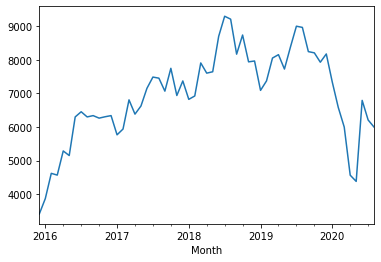

In [ ]:
y.plot()

In [ ]:
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
  
    # 各行列のトレンド成分に対するブロック行列を構築
    G[0,0] = 1
    H[0,0] = 1
    
    # トレンドモデルの推移行列の構築
    # 非定常過程でも対応できる推移行列を構築 
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [ ]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs)

In [ ]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [ ]:
# 前半48時点を学習データに121時点以降のデータを検証用に使用
n_train = 36
train, test = y.values[:n_train], y.values[n_train:]

In [ ]:
# filtered_state_means, filtered_state_covs = kf.filter(train)
# pred_o = filtered_state_means.dot(H.T)

In [ ]:
smoothed_state_means, smoothed_state_covs = kf.smooth(train)
pred_o_smoothed = smoothed_state_means.dot(H.T)

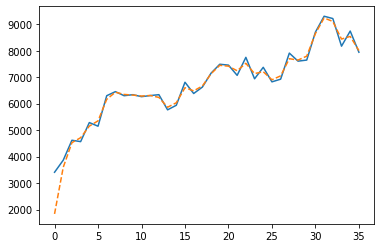

In [ ]:
plt.plot(train, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")

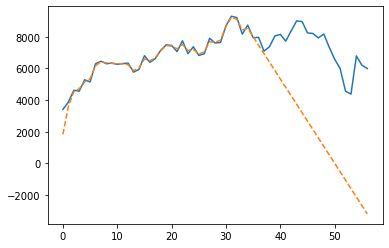

In [ ]:
plt.plot(y.values, label="observation")

# 長期予測格納用のベクトルを用意（値は全て入れ替わるため0で初期化しなくてよい）
pred_y = np.empty(len(test))

# 現在の状態と分散共分散行列を取得
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test)):
    # filter_updateは観測値を入力しなければ1期先予測のみを実行する
    current_state, current_cov = kf.filter_update(current_state, 
                                                  current_cov, 
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)
    
# np.hstackはnp.concatenateでもよい
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")